# Описание проекта

Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Подготовка данных

Путь к файлам:
- /datasets/gold_recovery_train.csv.
- /datasets/gold_recovery_test.csv.
- /datasets/gold_recovery_full.csv.

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error 
import seaborn as sns
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full.csv')

Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate — ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота <br>

Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи <br>

Наименование признаков должно быть такое: <br>
[этап].[тип_параметра].[название_параметра] <br>
Пример: rougher.input.feed_ag <br>

Возможные значения для блока [этап]: <br>
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики <br>

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

In [11]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [12]:
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [13]:
print(data_train[data_train['final.output.concentrate_ag'].isnull()].count())

date                                          72
final.output.concentrate_ag                    0
final.output.concentrate_pb                    0
final.output.concentrate_sol                   1
final.output.concentrate_au                    1
                                              ..
secondary_cleaner.state.floatbank5_a_level    13
secondary_cleaner.state.floatbank5_b_air      13
secondary_cleaner.state.floatbank5_b_level    14
secondary_cleaner.state.floatbank6_a_air      13
secondary_cleaner.state.floatbank6_a_level    13
Length: 87, dtype: int64


In [15]:
print(data_train[data_train['primary_cleaner.input.sulfate'].isnull()].count())

date                                          1307
final.output.concentrate_ag                   1252
final.output.concentrate_pb                   1252
final.output.concentrate_sol                  1248
final.output.concentrate_au                   1252
                                              ... 
secondary_cleaner.state.floatbank5_a_level    1233
secondary_cleaner.state.floatbank5_b_air      1233
secondary_cleaner.state.floatbank5_b_level    1234
secondary_cleaner.state.floatbank6_a_air      1224
secondary_cleaner.state.floatbank6_a_level    1233
Length: 87, dtype: int64


In [17]:
print(data_full[data_full['final.output.concentrate_ag'].isnull()].count())

date                                          89
final.output.concentrate_ag                    0
final.output.concentrate_pb                    2
final.output.concentrate_sol                   3
final.output.concentrate_au                    3
                                              ..
secondary_cleaner.state.floatbank5_a_level    15
secondary_cleaner.state.floatbank5_b_air      15
secondary_cleaner.state.floatbank5_b_level    16
secondary_cleaner.state.floatbank6_a_air      15
secondary_cleaner.state.floatbank6_a_level    15
Length: 87, dtype: int64


In [18]:
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


##### Вывод: есть различия между тренировочными данными и тестовыми. Те признаки, которые нет в тестовых, мы получаем в процессе очистки, а значит и в модели нам использовать не нужно. На входе у нас этих данных не будет.

In [19]:
names_train = []
for col in data_train.columns:
    if col != 'date':
        names_train.append(col)

In [20]:
len(names_train)

86

<Figure size 1440x360 with 0 Axes>

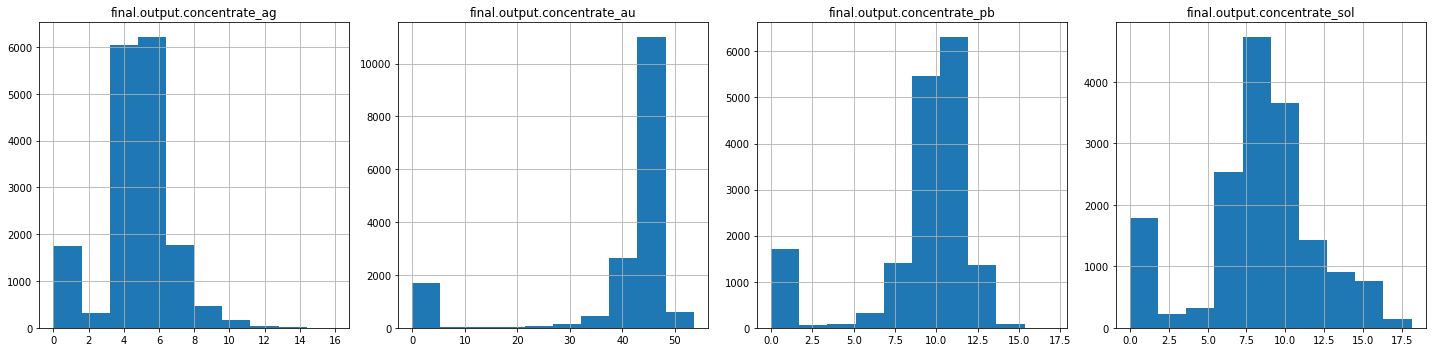

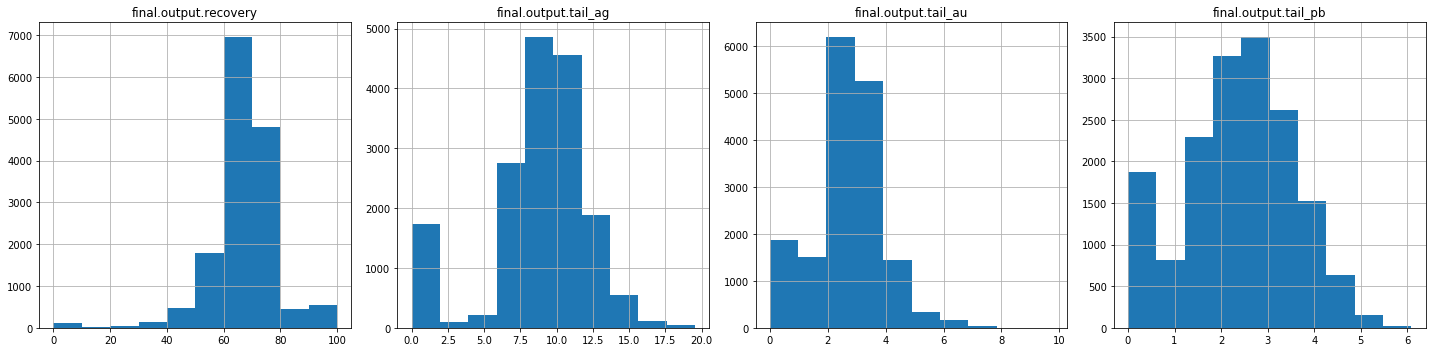

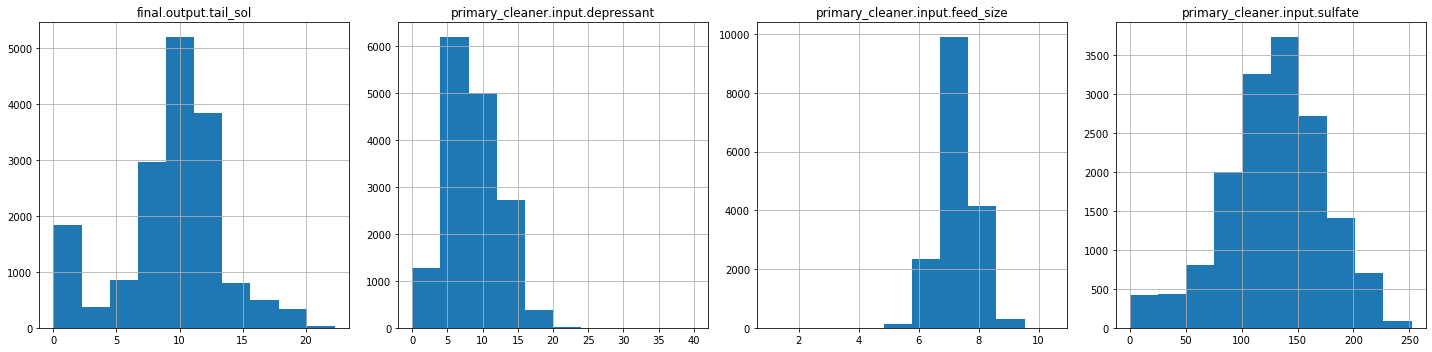

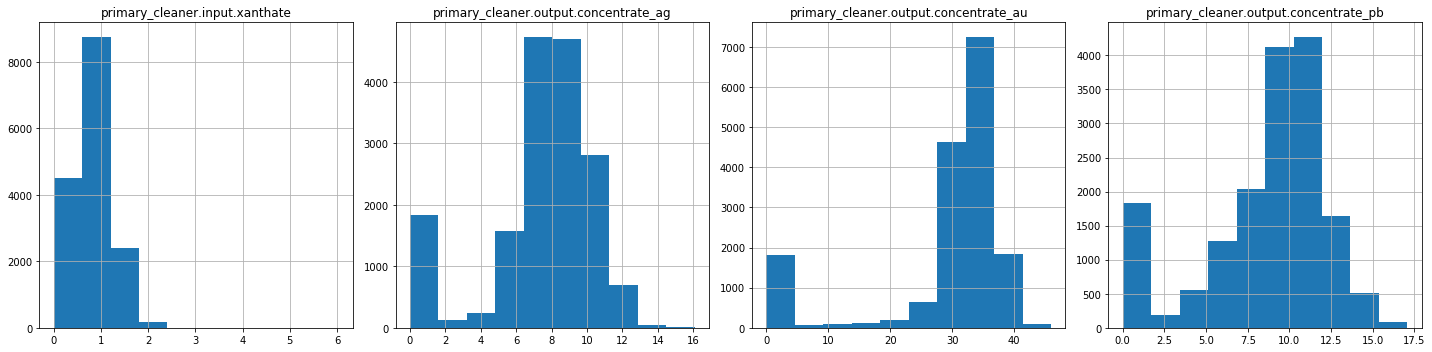

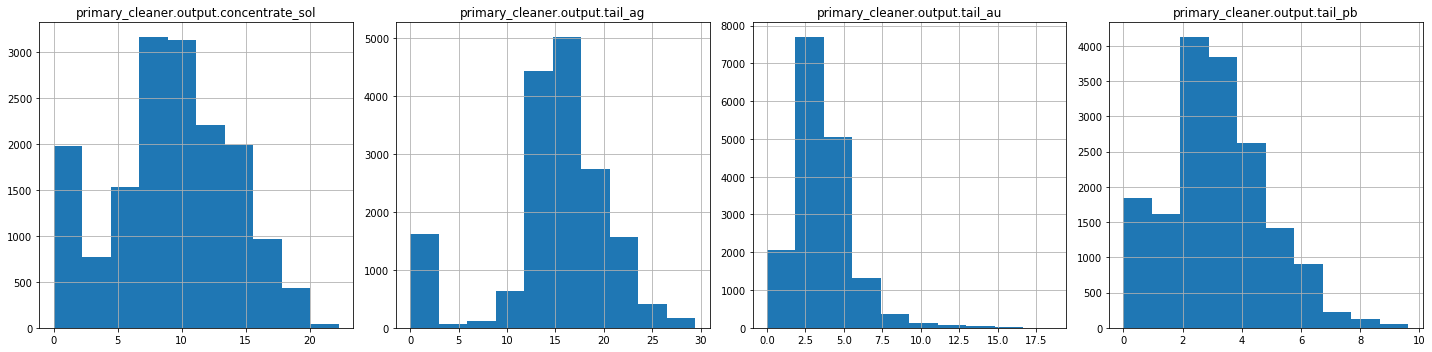

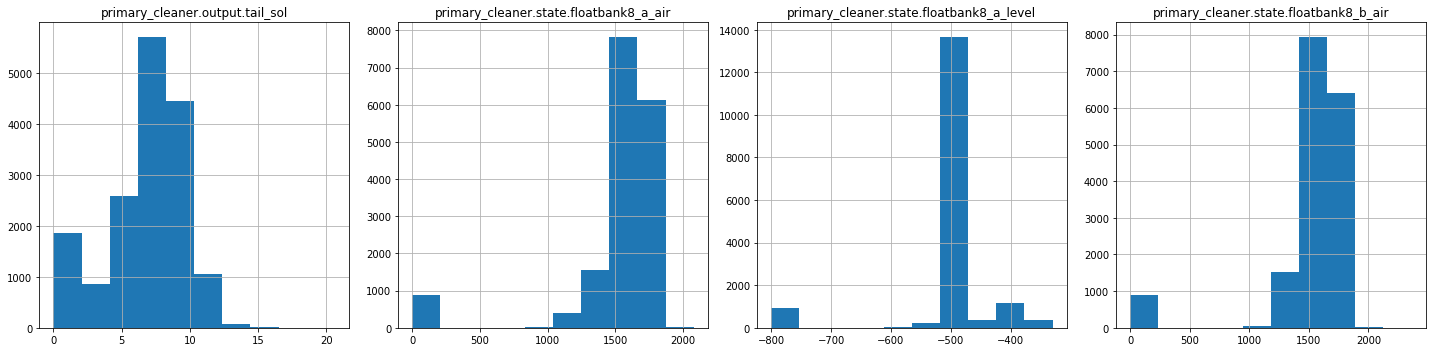

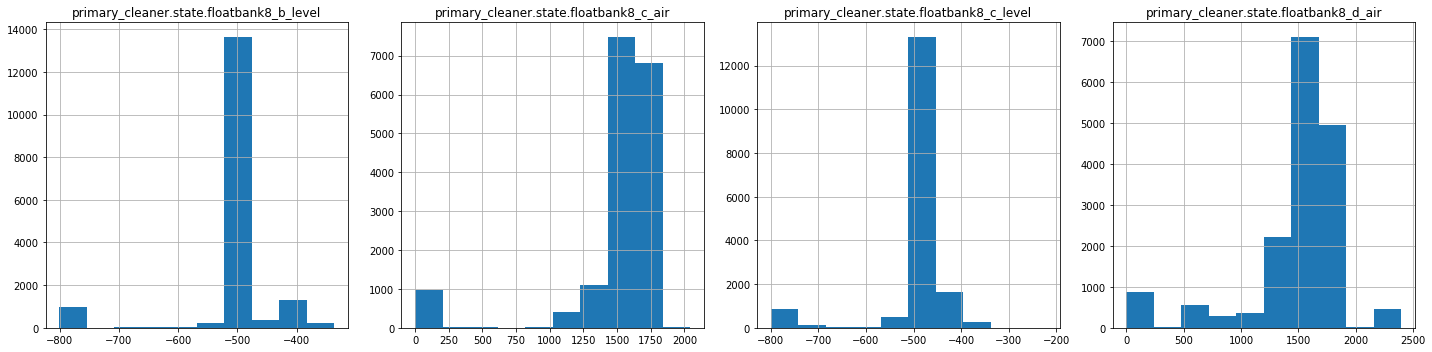

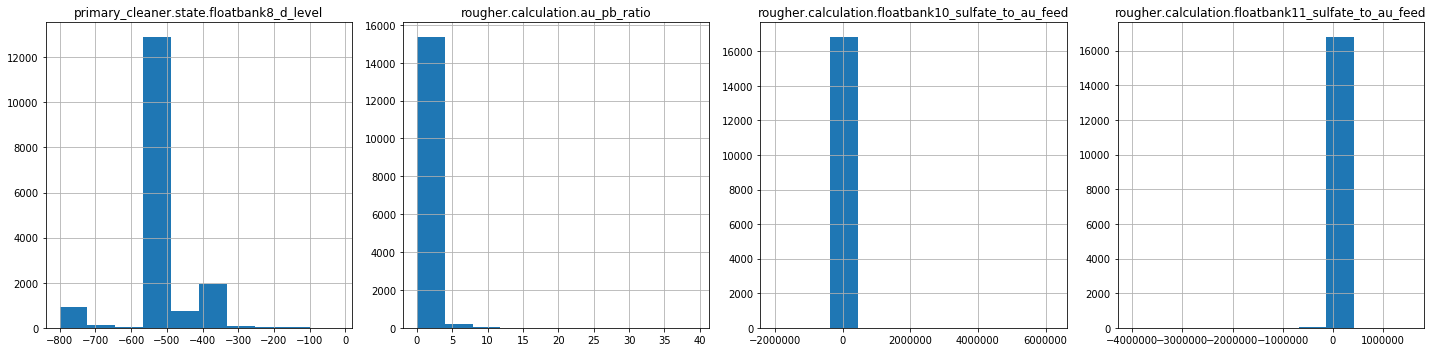

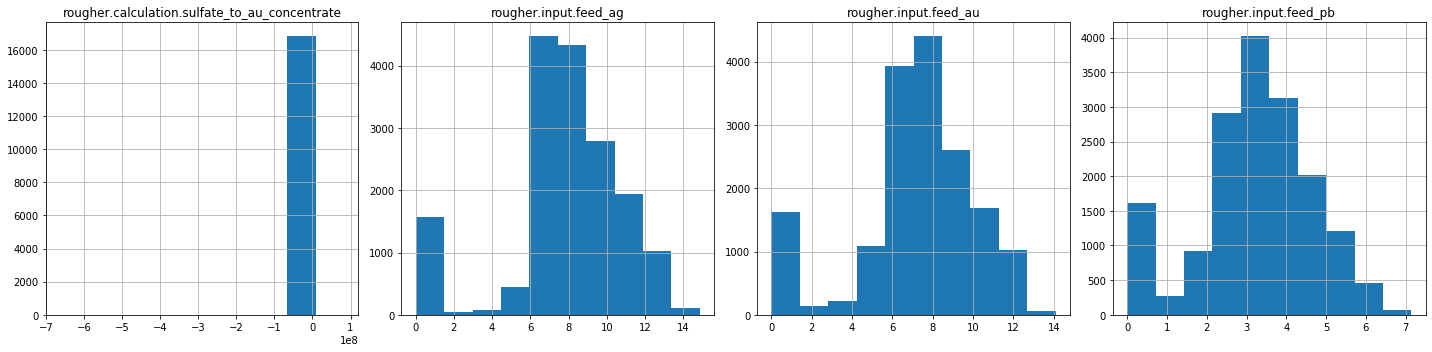

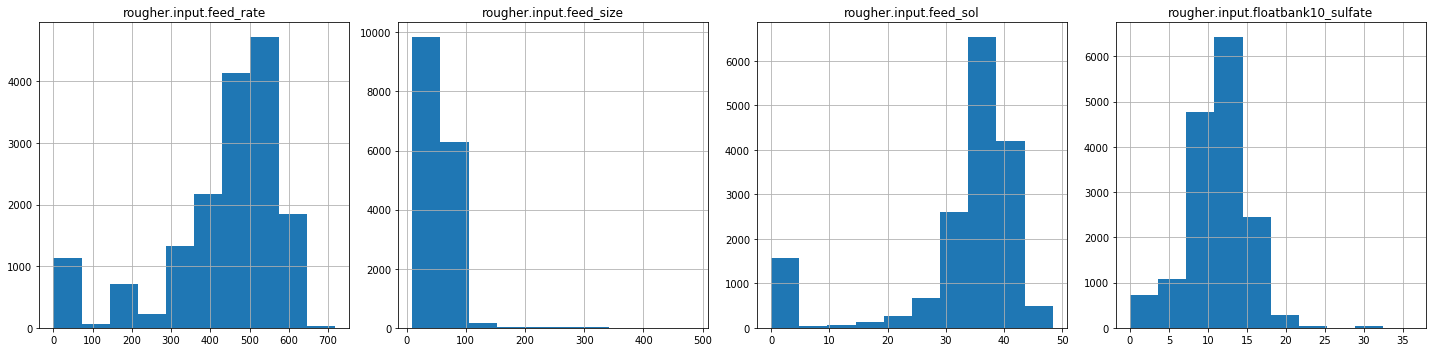

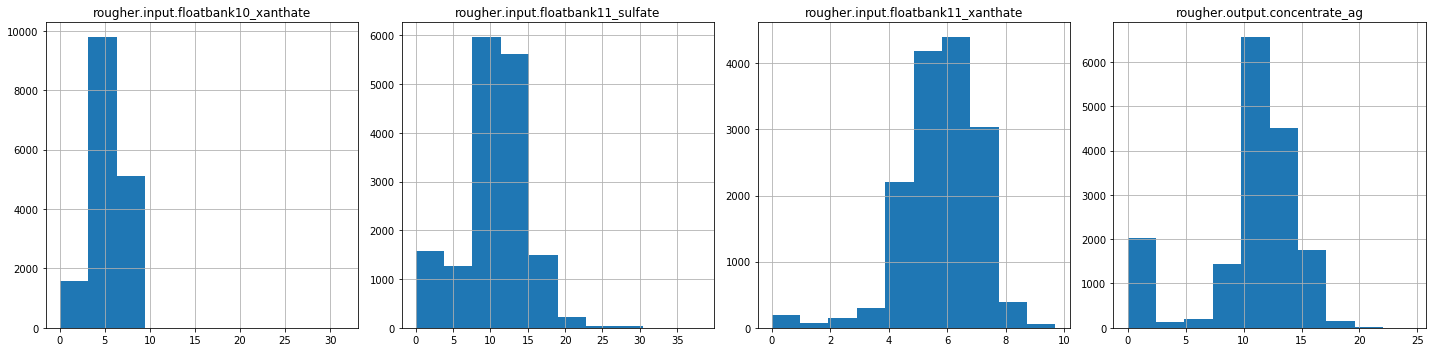

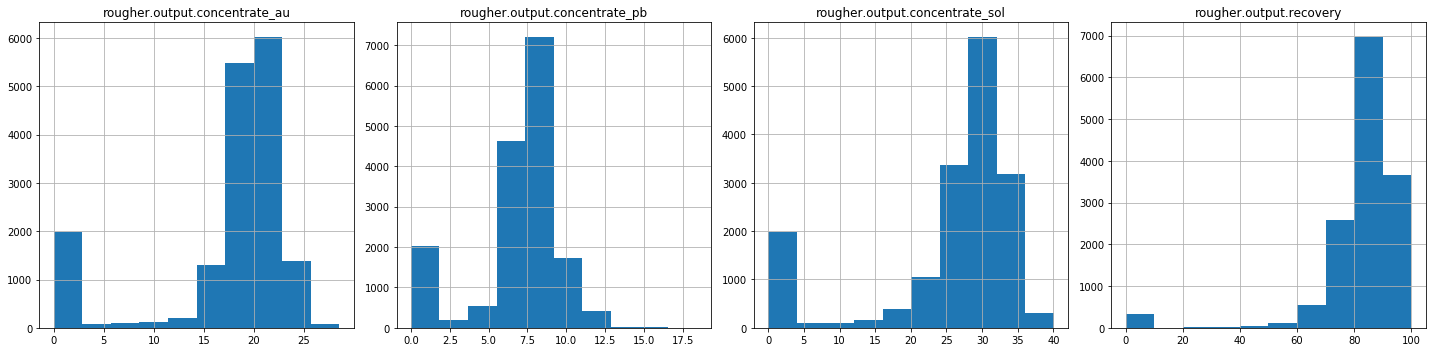

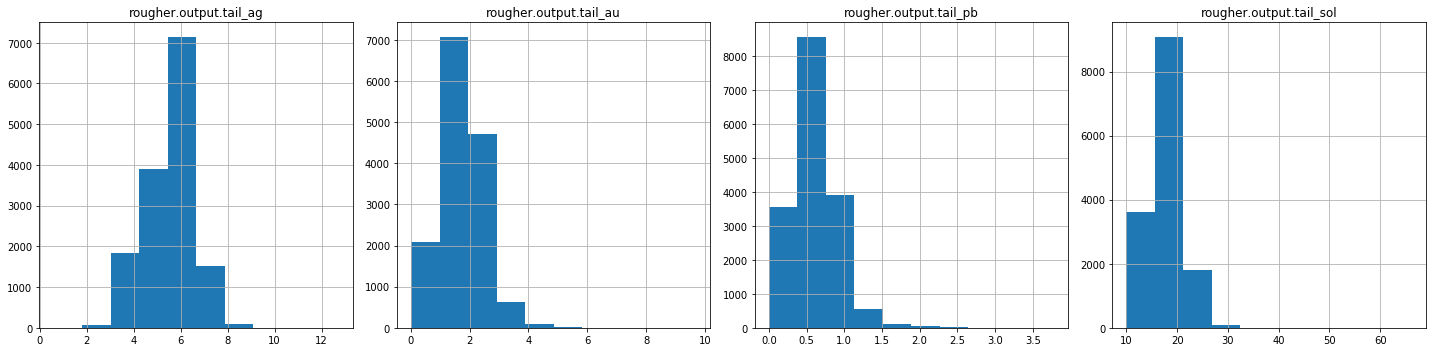

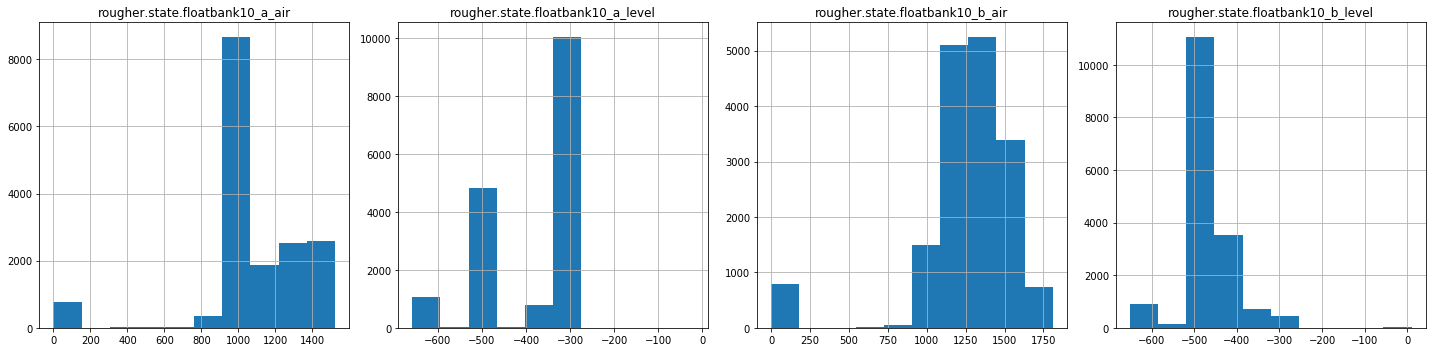

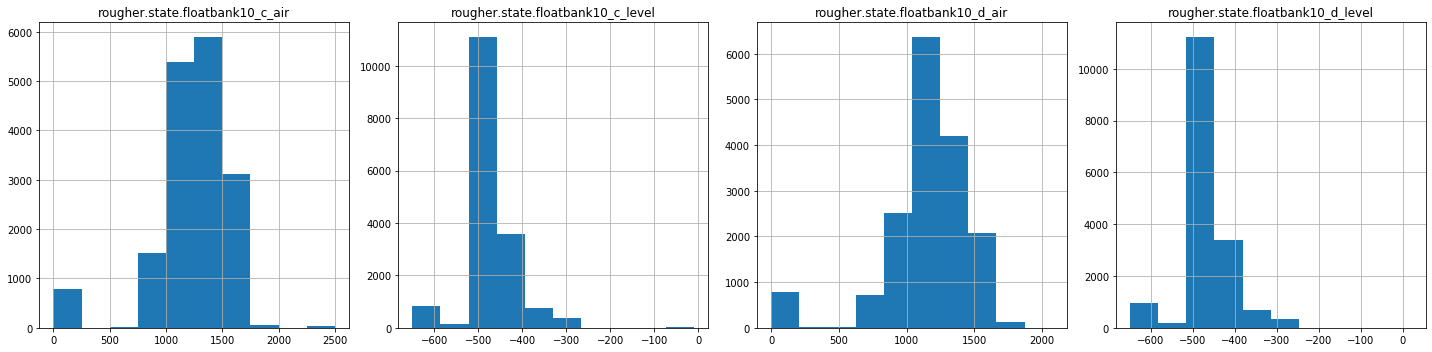

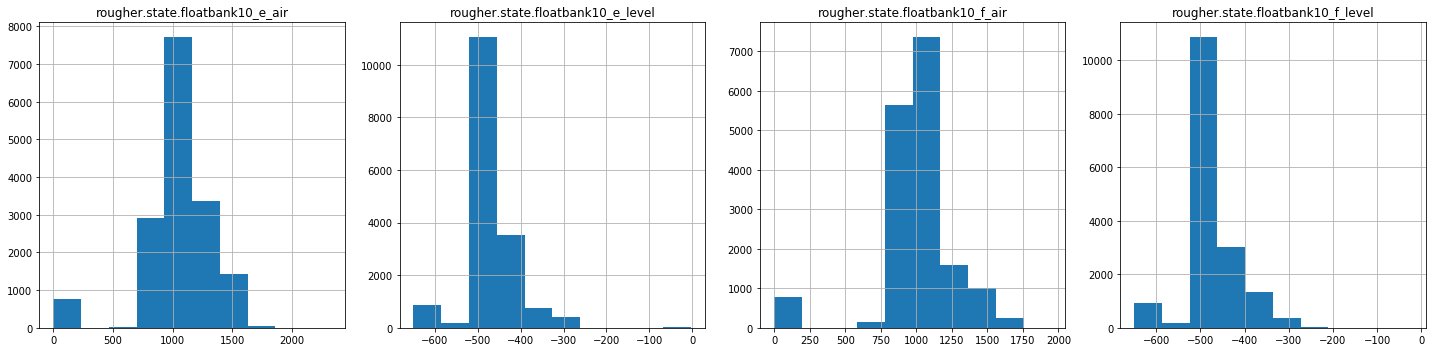

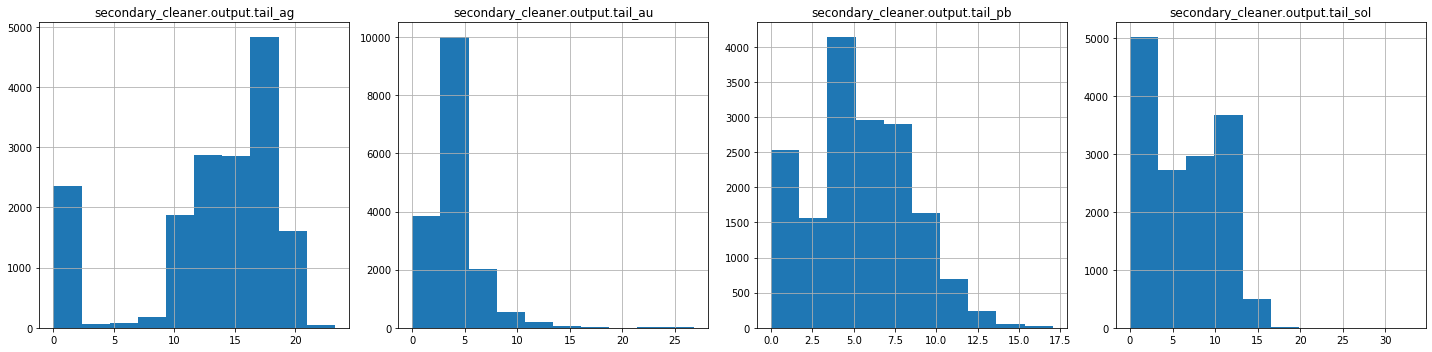

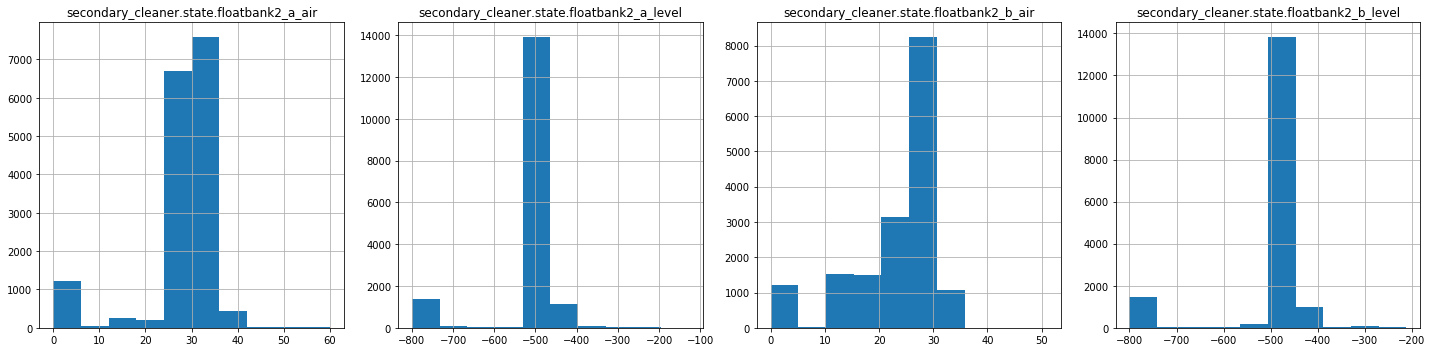

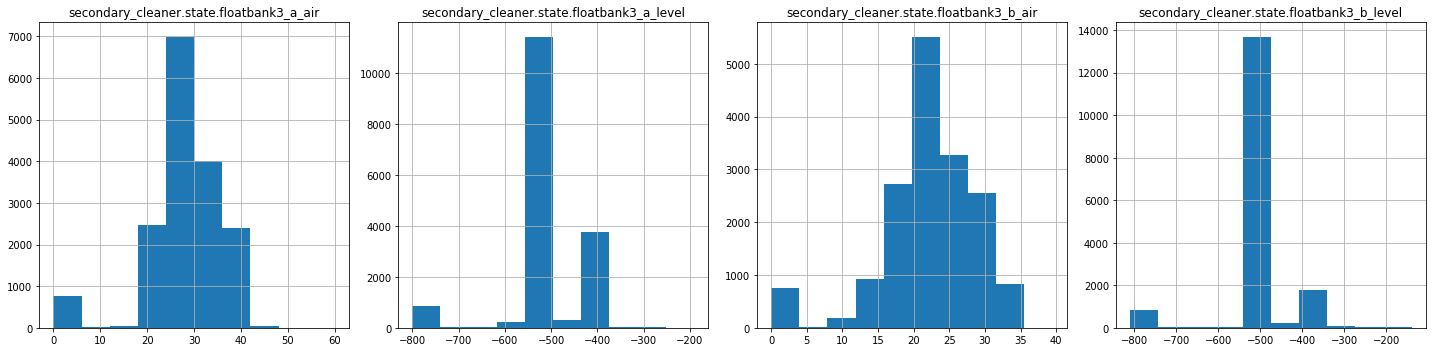

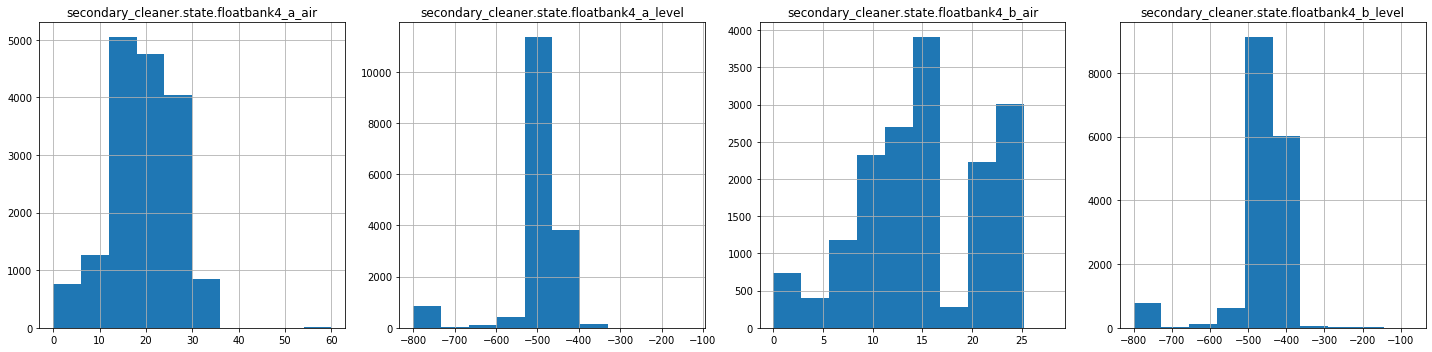

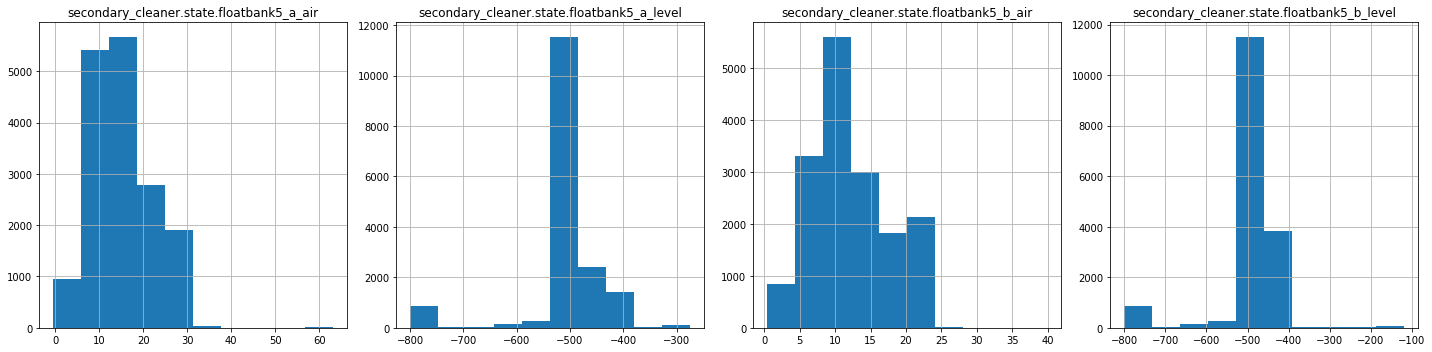

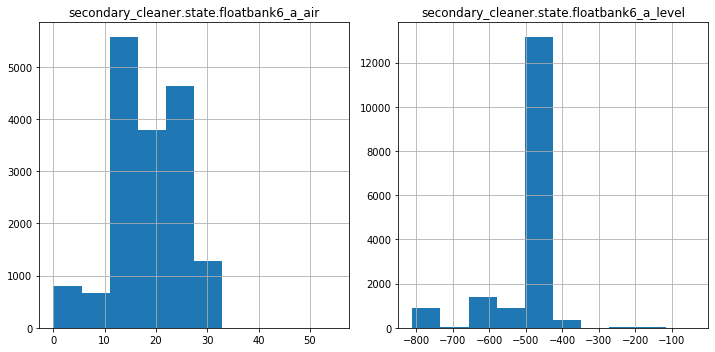

In [21]:
#Просмотрю значения всех столбцов на наличие выбивающихся значений
plt.figure(figsize=(20,5))
for i, name in enumerate(sorted(names_train)):
    data = data_train[name]
    if i%4 == 0:
        plt.figure(figsize=(20,5))
    plt.subplot(1,4,i%4+1)
    data.hist(range=(data.min(), data.max()))
    plt.title(name)
#plt.show()    
    plt.tight_layout() 
    if i%4 == 3: 
        plt.show()

В нескольких столбцах присутствует большое количество нулевых значений. 

### Проверю, что эффективность обогащения рассчитана правильно. Вычислю её на обучающей выборке для признака rougher.output.recovery. Найду MAE между моими расчётами и значением признака. 

МАЕ - среднее абсолютное отклонение.

In [22]:
data_train.isnull().sum()

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

In [23]:
data_train_MAE = data_train

In [24]:
data_train_MAE['rougher.output.recovery'].head()

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64

In [25]:
data_train_MAE = data_train_MAE.fillna(0)
data_train_MAE = data_train_MAE[~(data_train_MAE == 0).any(axis=1)]

Recovery = [C*(F-T)/F*(C-T)]*100% <br>
где:
- C — доля золота в концентрате после флотации/очистки; rougher.output.concentrate_au
- F — доля золота в сырье/концентрате до флотации/очистки; rougher.input.feed_au
- T — доля золота в отвальных хвостах после флотации/очистки. rougher.output.tail_au

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. <br>
Причём важен не только финальный продукт, но и черновой концентрат.



- rougher.output.tail_au, final.output.tail_au - отвальные хвосты
- rougher.output.concentrate_au, final.output.concentrate_au - концентрат

rougher - флотация
rougher Au - концентрат золота
input - сырье

In [26]:
c = data_train_MAE['rougher.output.concentrate_au']
f = data_train_MAE['rougher.input.feed_au']
t = data_train_MAE['rougher.output.tail_au']

data_train_MAE['recovery_calc'] =((c*(f-t))/(f*(c-t)))*100

In [27]:
data_train_MAE['recovery_calc']

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16841    90.384753
16842    88.478959
16843    87.793594
16844    90.466483
16845    90.577495
Name: recovery_calc, Length: 10285, dtype: float64

In [28]:
data_train_MAE = data_train_MAE.fillna(0)
data_train_MAE = data_train_MAE[~(data_train_MAE == 0).any(axis=1)]

In [29]:
print(data_train_MAE[data_train_MAE['recovery_calc'].isnull()].count())

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
recovery_calc                                 0
Length: 88, dtype: int64


In [30]:
round((mean_absolute_error(data_train_MAE['rougher.output.recovery'], data_train_MAE['recovery_calc'])), 2)

0.0

### Проанализирую признаки, недоступные в тестовой выборке.

In [31]:
names_test = []
for col in data_test.columns:
    if col != 'date':
        names_test.append(col)

In [32]:
len(names_train) - len(names_test)

34

34 признака отсутствуют в тестовой выборке. Посмотрю какие. 

<Figure size 1440x360 with 0 Axes>

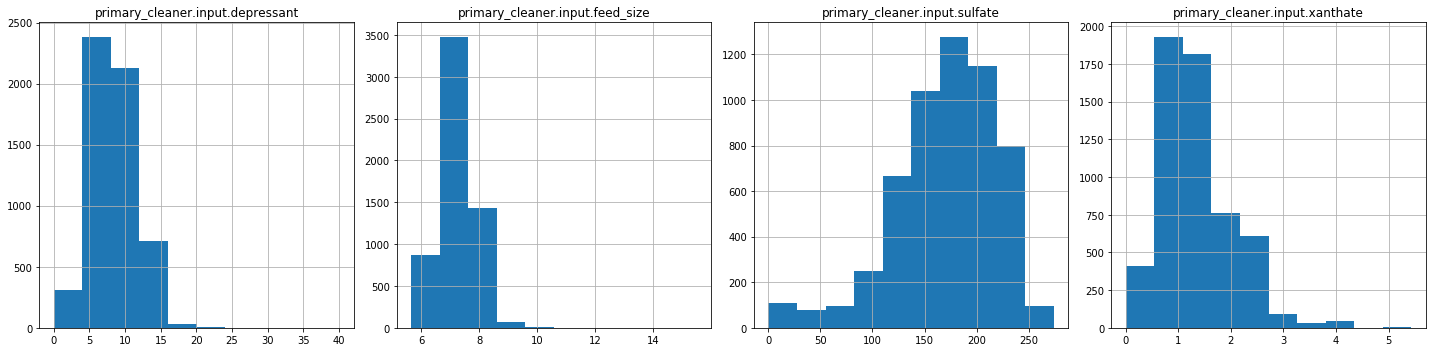

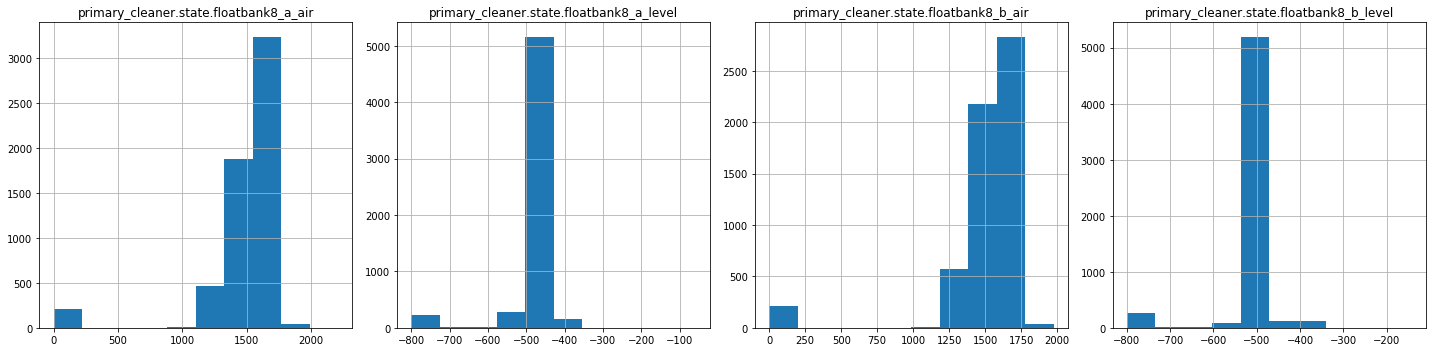

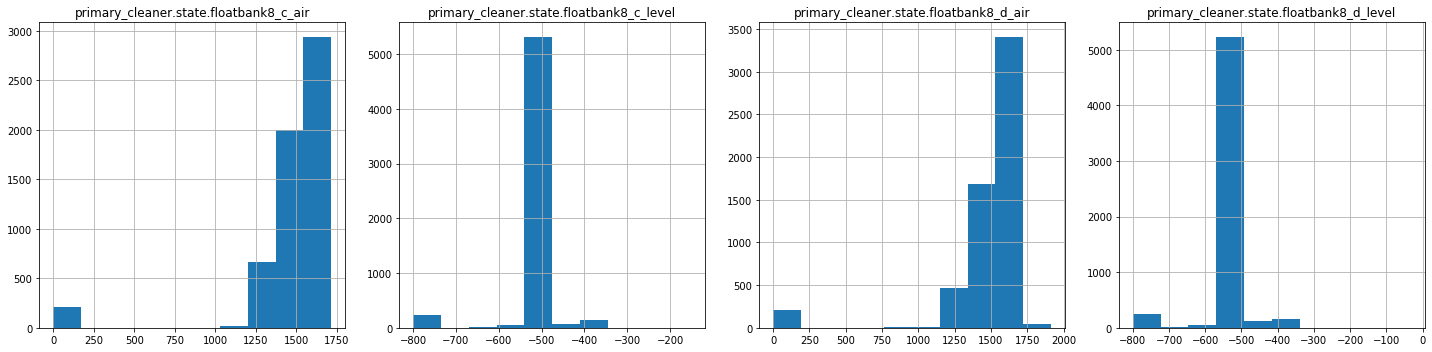

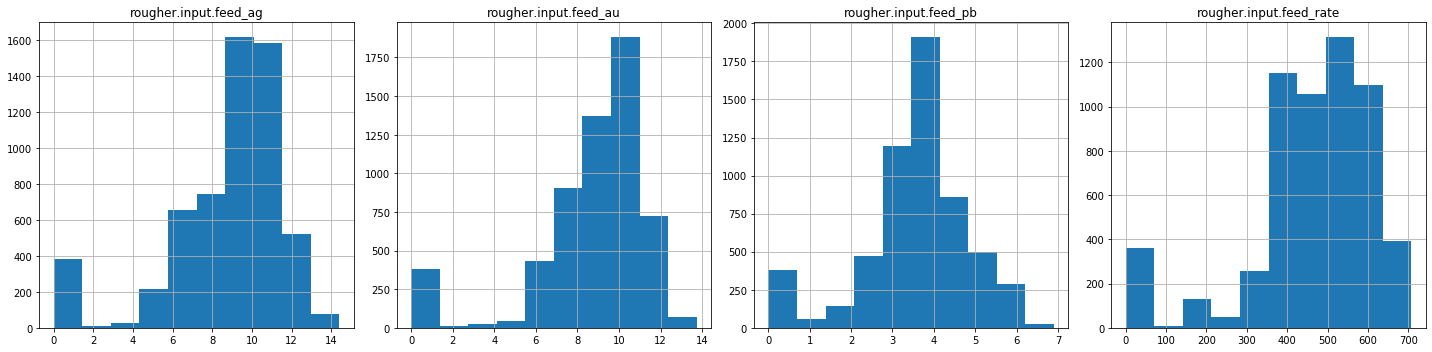

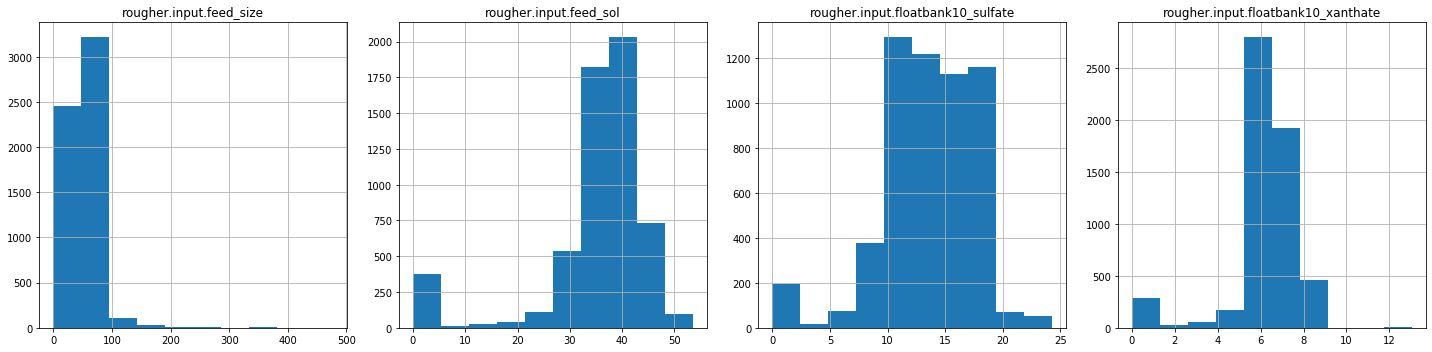

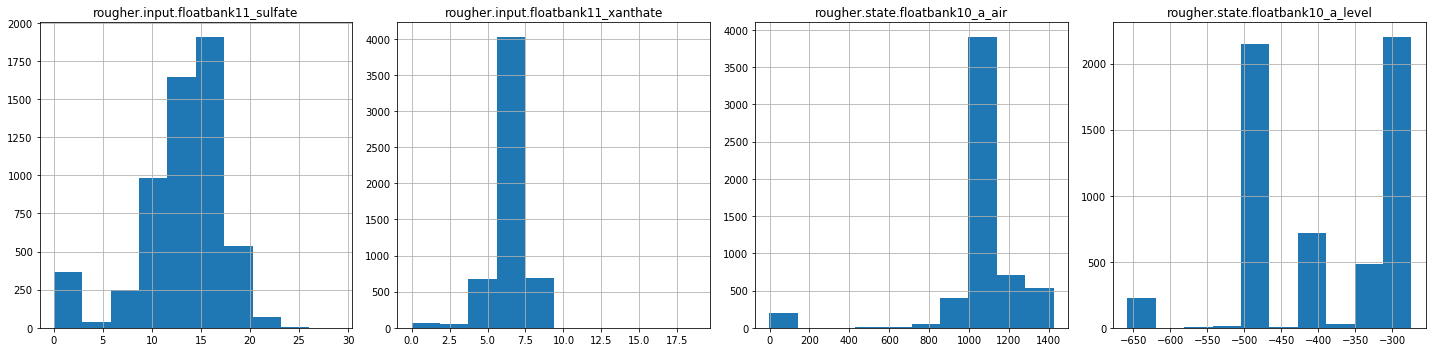

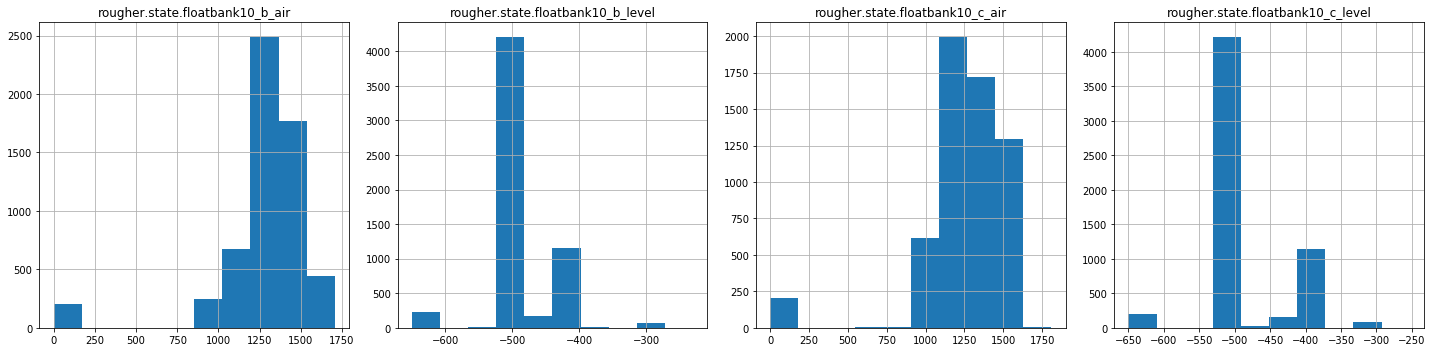

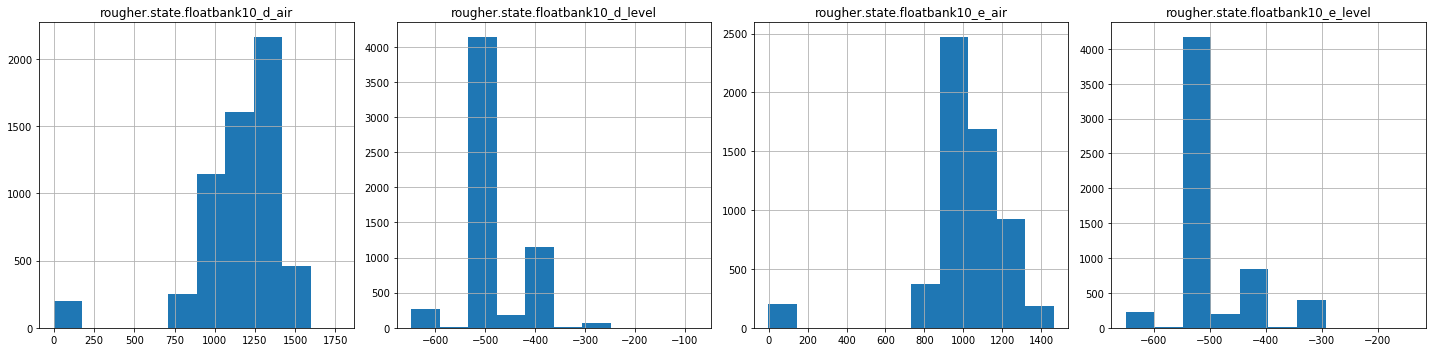

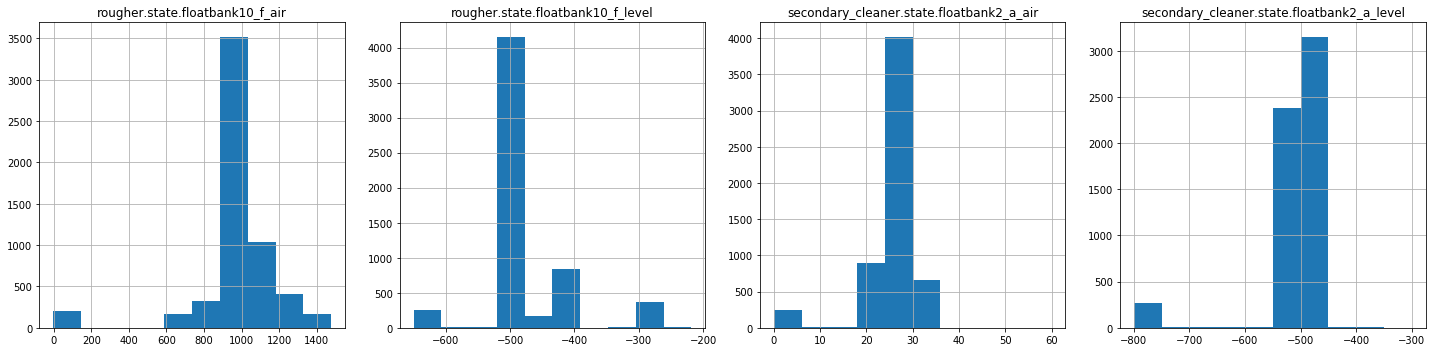

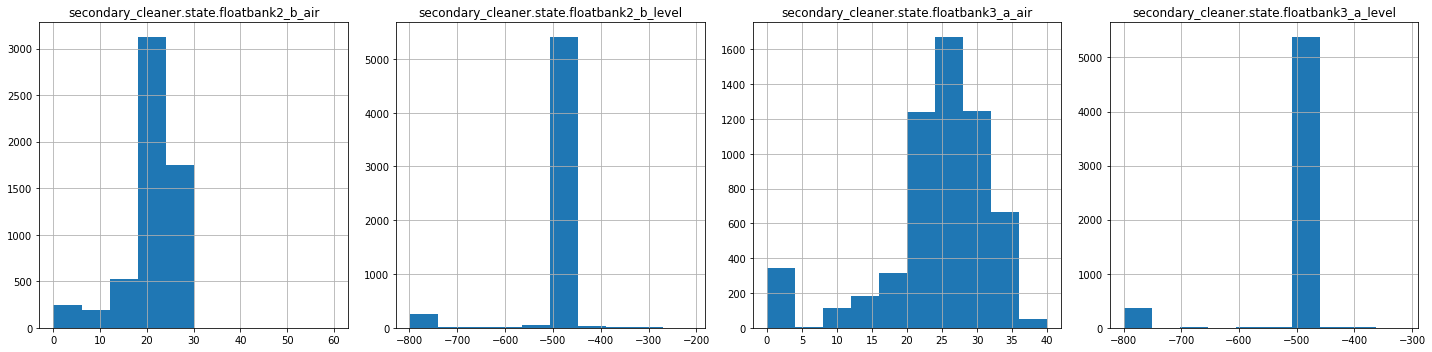

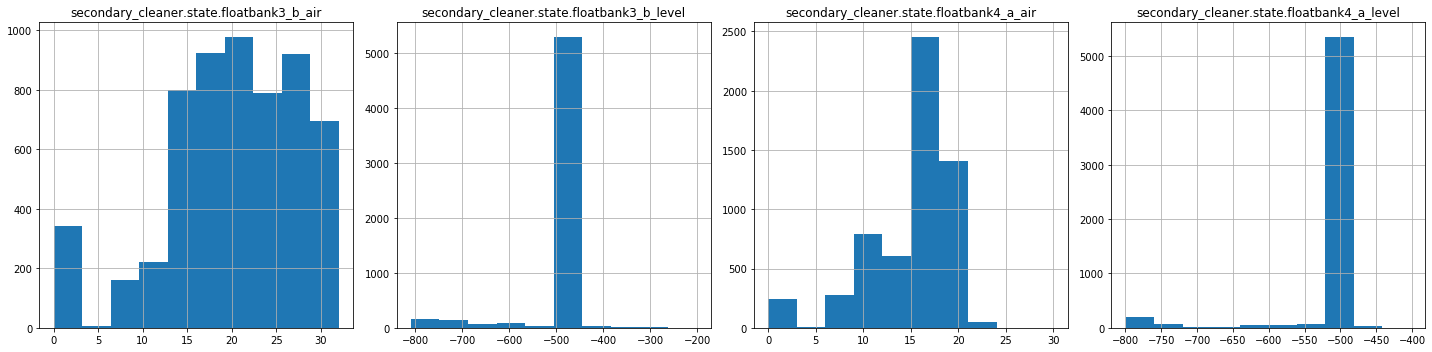

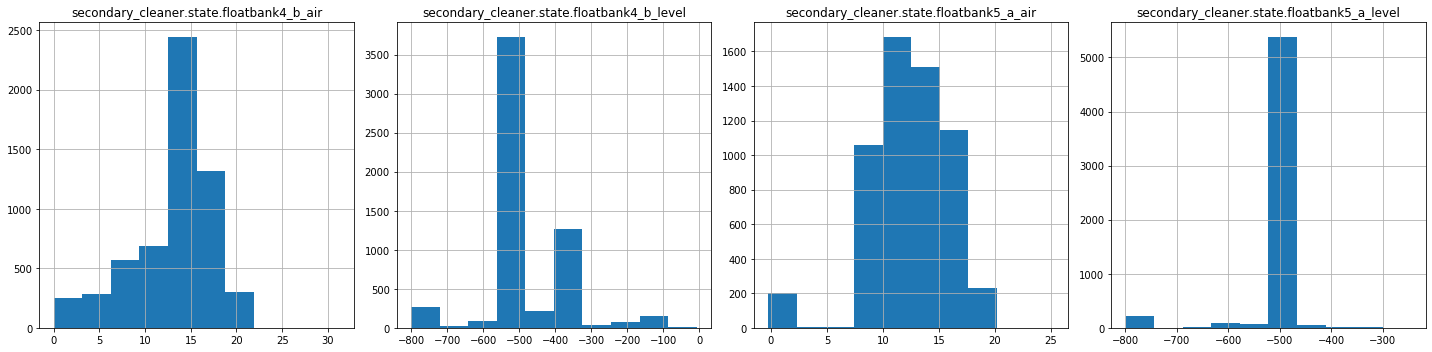

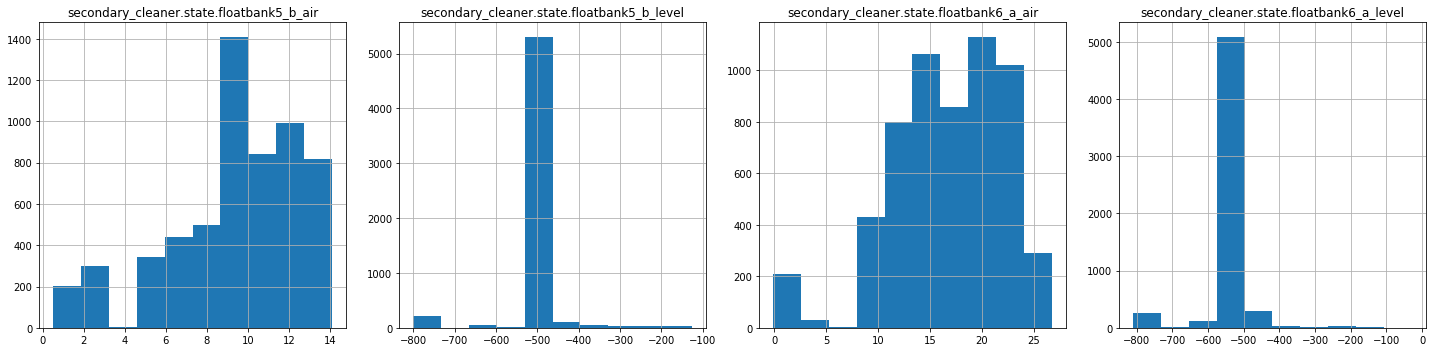

In [33]:
#Просмотрю значения всех столбцов на наличие выбивающихся значений
plt.figure(figsize=(20,5))
for i, name in enumerate(sorted(names_test)):
    data = data_test[name]
    if i%4 == 0:
        plt.figure(figsize=(20,5))
    plt.subplot(1,4,i%4+1)
    data.hist(range=(data.min(), data.max()))
    plt.title(name)
#plt.show()    
    plt.tight_layout() 
    if i%4 == 3: 
        plt.show()

In [34]:
train_test_difference = set(names_train).difference(names_test)

In [35]:
print("Missing values in data_test:", (train_test_difference))

Missing values in data_test: {'primary_cleaner.output.tail_pb', 'final.output.tail_ag', 'rougher.output.concentrate_au', 'rougher.output.tail_ag', 'final.output.tail_pb', 'final.output.concentrate_pb', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_au', 'rougher.output.concentrate_pb', 'final.output.concentrate_ag', 'primary_cleaner.output.tail_au', 'rougher.output.concentrate_ag', 'rougher.output.tail_sol', 'primary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_au', 'primary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.concentrate_pb', 'rougher.output.recovery', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'rougher.calculation.sulfate_to_au_concentrate', 'primary_cleaner.output.concentrate_au', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.concentrate_ag', 'final.output

##### Вывод: 
В тренировочной выборке отсутствуют данные output, данные о продукте на разных этапах производства. <br>
Все эти признаки типа float64.
Необходимо добавить столбцы rougher.output.recovery и final.output.recovery, чтобы в дальнейшем можно было проверить модели для целевых признаков.

**************************

In [36]:
data_train_model = data_train.drop(columns=train_test_difference)

In [37]:
data_train_model.shape

(16860, 53)

## Проведите предобработку данных

In [38]:
data_train_model.ffill(inplace=True)
data_test.ffill(inplace=True)

In [39]:
#Проверяю наличие пропусков в data_train
data_train_model.isna().any().sum()

0

In [40]:
#Проверяю наличие пропусков в data_test
data_test.isna().any().sum()

0

# Анализ данных

### Посмотрю, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

In [41]:
au_cols = [col for col in data_train.columns if 'concentrate_au' in col]
ag_cols = [col for col in data_train.columns if 'concentrate_ag' in col]
pb_cols = [col for col in data_train.columns if 'concentrate_pb' in col]

In [42]:
agents = ['Au', 'Ag', 'Pb']
cols = [au_cols, ag_cols, pb_cols]

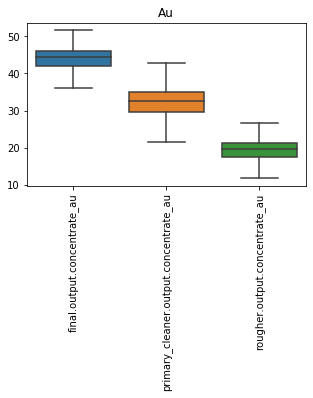

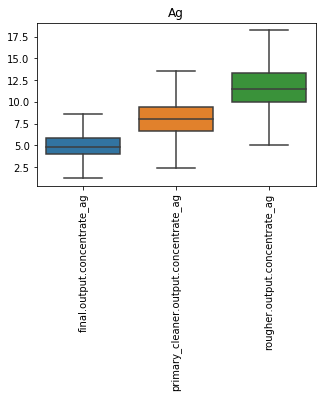

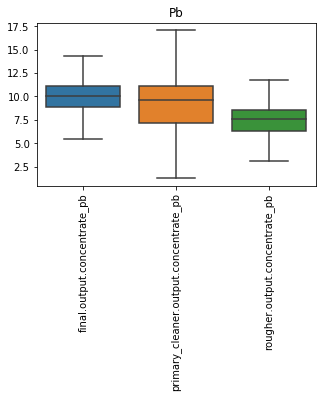

In [43]:
for col, agent in zip(cols, agents):
    plt.figure(figsize=(5,3))
    sns.boxplot(data=data_train[col],showfliers=False)
    plt.title(agent)
    plt.subplot()
    plt.xticks(rotation=90)

##### Вывод:
В сырье концентрация Au минимальна, в черновом - больше, и максимальная концентрация - в финальном концентрате. Содержание Ag имеет обратную зависимость - максимальная концентрация - в сырье. Значение Pb после первичной обработки практически не меняется. 

### Сравню распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [44]:
fs_cols = [col for col in data_test.columns if 'feed_size' in col]
fs_cols

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

In [45]:
dfs = [data_test, data_train]

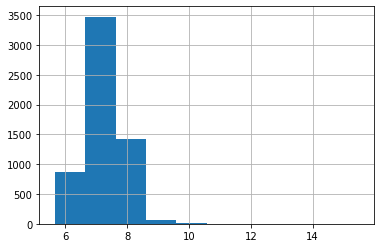

In [46]:
data_test['primary_cleaner.input.feed_size'].hist()

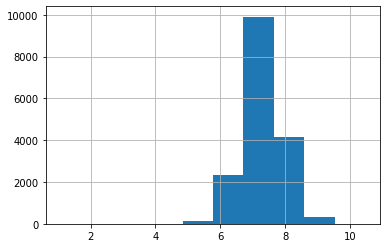

In [47]:
data_train['primary_cleaner.input.feed_size'].hist()

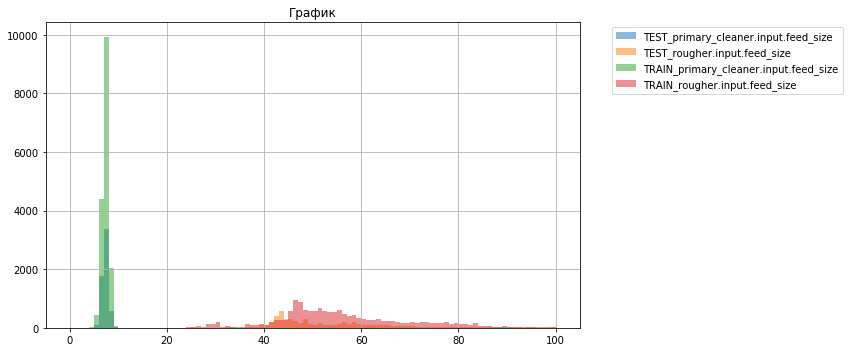

In [48]:
plt.figure(figsize=(12,5))
labels = ['TEST_primary_cleaner.input.feed_size', 'TEST_rougher.input.feed_size', 'TRAIN_primary_cleaner.input.feed_size', 'TRAIN_rougher.input.feed_size']
for df in dfs:
    for col in fs_cols:
        df[col].hist(range=(0,100), bins=100, alpha=0.5)
        plt.subplot()
    plt.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('График')
plt.tight_layout()  

##### Вывод: размеры гранул сильно не отличаются друг от друга в двух выборках.

### Исследую суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

##### Финальный концентрат

In [49]:
final_cocentrate = data_full.filter(like='final.output.concentrate', axis=1) 
final_cocentrate['final_sum_conc'] = final_cocentrate.sum(axis=1, skipna = True)

In [50]:
final_cocentrate['final_sum_conc'].describe()

count    22716.000000
mean        62.166910
std         20.954107
min          0.000000
25%         67.005682
50%         69.230638
75%         71.127337
max         80.210644
Name: final_sum_conc, dtype: float64

Text(0.5, 1.0, 'Суммарная концентрация веществ в финальном концентрате')

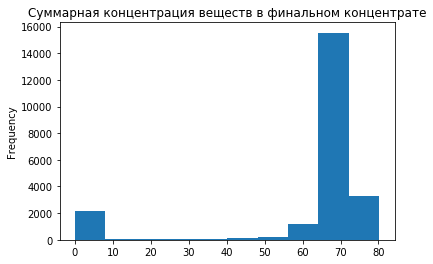

In [51]:
final_cocentrate['final_sum_conc'].plot(kind='hist')
plt.title('Суммарная концентрация веществ в финальном концентрате')

##### Сырье 

In [52]:
primary_cocentrate = data_full.filter(like='primary_cleaner.output.concentrate', axis=1) 
primary_cocentrate['primary_sum_conc'] = primary_cocentrate.sum(axis=1, skipna = True)

In [53]:
primary_cocentrate['primary_sum_conc'].describe()

count    22716.000000
mean        54.727256
std         20.057935
min          0.000000
25%         56.112483
50%         61.693976
75%         65.286862
max         80.749343
Name: primary_sum_conc, dtype: float64

Text(0.5, 1.0, 'Суммарная концентрация веществ в сырье')

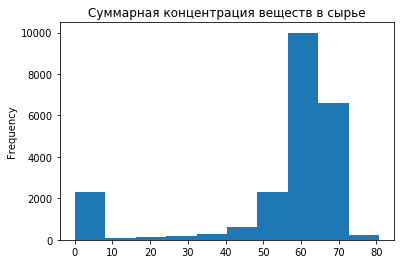

In [54]:
primary_cocentrate['primary_sum_conc'].plot(kind='hist')
plt.title('Суммарная концентрация веществ в сырье')

##### Черновой концентрат

In [55]:
rougher_cocentrate = data_full.filter(like='rougher.output.concentrate', axis=1) 
rougher_cocentrate['rougher_sum_conc'] = rougher_cocentrate.sum(axis=1, skipna = True)

In [56]:
rougher_cocentrate['rougher_sum_conc'].describe()

count    22716.000000
mean        61.378090
std         23.558863
min          0.000000
25%         63.263228
50%         69.399690
75%         74.015593
max         90.964431
Name: rougher_sum_conc, dtype: float64

Text(0.5, 1.0, 'Суммарная концентрация веществ в черновом концентрате')

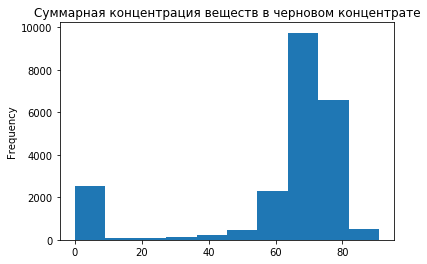

In [57]:
rougher_cocentrate['rougher_sum_conc'].plot(kind='hist')
plt.title('Суммарная концентрация веществ в черновом концентрате')

##### Вывод: очень много нулевых значений. Думаю, их лучше удалить.

In [58]:
for col in data_train:
    data_train.drop(data_train[data_train[col] == 0].index , inplace=True)

In [59]:
for col in data_test:
    data_test.drop(data_test[data_test[col] == 0].index , inplace=True)

In [60]:
for col in data_full:
    data_full.drop(data_full[data_full[col] == 0].index , inplace=True)

# Модель

### Напишу функцию для вычисления итоговой sMAPE.

In [61]:
def smape (target, predicted):
    x = (abs(target - predicted))/((abs(target) + abs(predicted))/2)*100
    x = x.sum()
    return ((1/len(target))*x)

In [62]:
def final_smape():
    x = (0.25*smape(target_rougher_test, predicted_rougher))+(0.75*smape(target_final_test, predicted_final))
    return x

##### Целевые параметры

In [63]:
target_rougher_train = data_train['rougher.output.recovery'].loc[data_train_model.index].reset_index(drop=True)
target_rougher_test = data_full['rougher.output.recovery'].loc[data_test.index].reset_index(drop=True)

target_final_train = data_train['final.output.recovery'].loc[data_train_model.index].reset_index(drop=True)
target_final_test = data_full['final.output.recovery'].loc[data_test.index].reset_index(drop=True)

In [64]:
features_train = data_train_model.drop(columns=['date'])
features_test = data_test.drop(columns=['date'])

In [65]:
data_train_model.shape

(16860, 53)

In [66]:
features_train.ffill(inplace=True)
features_test.ffill(inplace=True)
target_rougher_test.ffill(inplace=True)
target_final_test.ffill(inplace=True)
target_rougher_train.ffill(inplace=True)
target_final_train.ffill(inplace=True)

##### Модель "Линейная регрессия" 

In [67]:
model_rougher = LinearRegression()
model_rougher.fit(features_train, target_rougher_train)
predicted_rougher = model_rougher.predict(features_test)

In [68]:
model_final = LinearRegression()
model_final.fit(features_train, target_final_train)
predicted_final = model_final.predict(features_test)

In [69]:
smape(target_rougher_test, predicted_rougher)

12.50069946505722

In [70]:
smape(target_final_test, predicted_final)

14.050917501719738

In [71]:
final_smape()

13.66336299255411

Получила значение метрики для двух моделей. Попробую построить другую модель - случайный лес.

In [72]:
my_scorer = make_scorer(smape, greater_is_better=False)

## Обучаю модели

##### Модель "Случайный лес" с подбором параметров

In [73]:
model = RandomForestRegressor(random_state=12345)
parameters = {'n_estimators': range(5,7), 'max_depth': range(2,6)}
grid = GridSearchCV(model, parameters, scoring = my_scorer, cv=3)
grid.fit(features_train, target_rougher_train)

print('Оптимальные параметры модели:', grid.best_params_)
smape_rougher = grid.best_score_
print('sMAPE(rougher)', smape_rougher)

grid.fit(features_train, target_final_train)
print('Оптимальные параметры модели:', grid.best_params_)
smape_final = grid.best_score_
print('sMAPE(final)', smape_final)
smape_all = 0.25*smape_rougher + 0.75*smape_final
print('Итоговое sMAPE', smape_all)

Оптимальные параметры модели: {'max_depth': 4, 'n_estimators': 6}
sMAPE(rougher) -10.005920045059822
Оптимальные параметры модели: {'max_depth': 2, 'n_estimators': 5}
sMAPE(final) -15.04956613502049
Итоговое sMAPE -13.788654612530323


##### Тестирование модели

In [74]:
RF_model_rougher = RandomForestRegressor(random_state=12345, n_estimators=4, max_depth=6) 
RF_model_rougher.fit(features_test, target_rougher_test) 
predictions_test_rougher = RF_model_rougher.predict(features_test)
result_test_rougher = smape(target_rougher_test, predictions_test_rougher) 
 
print("sMAPE модели для rougher:", result_test_rougher)

sMAPE модели для rougher: 6.8265800031532935


In [75]:
RF_model_final = RandomForestRegressor(random_state=12345, n_estimators=2, max_depth=5) 
RF_model_final.fit(features_test, target_final_test) 
predictions_test_final = RF_model_final.predict(features_test)
result_test_final = smape(target_final_test, predictions_test_final) 
 
print("sMAPE модели для final:", result_test_final)

sMAPE модели для final: 8.730015395511808


##### Выводы: была получена модель предсказания коэффициента восстановления золота из золотосодержащей руды, которая была проверена на тестовой выборке после подбора параметров.  <br>
Итоговые значения метрики:
- sMAPE модели для rougher: 6.82
- sMAPE модели для final: 8.73


Сравню результат получившейся модели с простейшей константной моделью:

In [77]:
median_rougher = pd.Series(target_rougher_train.median(), index=target_rougher_test.index)
median_final = pd.Series(target_final_train.median(), index=target_final_test.index)
result = 0.25*smape(target_rougher_test, median_rougher)+0.75*smape(target_final_test, median_final)
print('Результат на тестовой выборке:', result)

Результат на тестовой выборке: 11.438958400837189
